**MODELLING**
---------

In this notebook, we will build a model to forecast future 3 years of rent based on historical data. We will also build an additional model with external features included to find influential features on rental price.

In [4]:

import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('scripts')
from scripts import modelling
importlib.reload(modelling)
from scripts.modelling import forecast_sarima

ImportError: cannot import name 'modelling' from 'scripts' (unknown location)

In [5]:
df = pd.read_csv('../data/curated/historical_rental_data.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [6]:


#Removing uneccessary columns
df_cleaned = df.drop(columns=[
    'Year', 'Month', 'Quarter', 
    'Is_Summer', 'Is_Autumn', 'Is_Winter', 'Is_Spring', 'Time_Since_Start',
    'Rent_Lag_1', 'Rent_Lag_3', 'Rent_Lag_12', 'Rent_MA_3', 'Rent_MA_12'
])


df_cleaned['Target_Rent'] = df_cleaned['Log_Rent'].fillna(df_cleaned['Rent'])

df_cleaned = df_cleaned.dropna(subset=['Target_Rent'])

def forecast_sarima(df):
    results = []
    no_results = 0

    # Loop over unique Suburb and Property_Type combinations
    unique_combinations = df[['Suburb', 'Property_Type']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        suburb = row['Suburb']
        prop_type = row['Property_Type']
        print(f"Processing: {suburb} - {prop_type}")

        # Subset the data for this suburb and property type
        subset = df[(df['Suburb'] == suburb) & (df['Property_Type'] == prop_type)]

        # Sort data by date and ensure monthly frequency
        subset = subset.sort_values(by='Date').set_index('Date')

        # Handle duplicate dates by aggregating them (e.g., using mean)
        # Only aggregate numeric columns
        numeric_cols = subset.select_dtypes(include=[np.number]).columns
        subset = subset.groupby(subset.index)[numeric_cols].mean()
        
        subset = subset[['Rent']]

        # Handle NaN values (impute or drop)
        subset = subset.fillna(method='ffill').dropna()

        # Ensure data is non-empty and has sufficient length
        if subset.empty or len(subset) < 36:  # Skip if not enough data for a 3-year forecast
            print(f"Skipping {suburb} - {prop_type} due to insufficient data")
            continue

        # Fit SARIMA model
        try:
            model = SARIMAX(subset, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = model.fit(disp=False)

            # Forecast the next 36 months (3 years)
            forecast = sarima_fit.get_forecast(steps=36)
            forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
            forecast_values = forecast.predicted_mean

            # Store results in a DataFrame
            forecast_df = pd.DataFrame({
                'Suburb': suburb,
                'Property_Type': prop_type,
                'Date': forecast_dates,
                'Forecasted_Rent': forecast_values
            })
            results.append(forecast_df)

            # Plot the forecast
            plt.figure(figsize=(10, 6))
            plt.plot(subset.index, subset['Rent'], label='Actual Rent')
            plt.plot(forecast_dates, forecast_values, label='Forecasted Rent', color='orange')
            plt.title(f"SARIMA Rent Forecast for {suburb} - {prop_type}")
            plt.xlabel('Date')
            plt.ylabel('Rent')
            plt.legend()
            
            # Save the plot
            suburb_folder = f"../plots/modelling_plots/{suburb.replace(' ', '_')}/"
            os.makedirs(suburb_folder, exist_ok=True)
            plt.savefig(f"{suburb_folder}{suburb.replace(' ', '_')}_{prop_type.replace(' ', '_')}_forecast.png")
            plt.close()

        except Exception as e:
            print(f"Failed to fit SARIMA model for {suburb} - {prop_type}: {str(e)}")
            no_results += 1

    # Combine all forecast results into a single DataFrame
    if results:
        forecast_results_df = pd.concat(results, axis=0)
        return forecast_results_df
    else:
        raise ValueError(f"No forecasts were generated. {no_results} suburb-property combinations failed.")


# Apply SARIMA forecasting and output forecast results
forecast_df = forecast_sarima(df_cleaned)

# Save forecast results to a CSV file
forecast_df.to_csv('../data/curated/forecast_results.csv', index=False)


Processing: Albert Park-Middle Park-West St Kilda - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Armadale - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Carlton North - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Carlton-Parkville - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: CBD-St Kilda Rd - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000

Processing: Collingwood-Abbotsford - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: East Melbourne - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: East St Kilda - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Elwood - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy North-Clifton Hill - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Flemington-Kensington - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: North Melbourne-West Melbourne - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Port Melbourne - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Prahran-Windsor - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Richmond-Burnley - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Melbourne - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: South Yarra - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Southbank - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: St Kilda - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Toorak - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Balwyn - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Blackburn - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Box Hill - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bulleen-Templestowe-Doncaster - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Burwood-Ashburton - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Camberwell-Glen Iris - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Chadstone-Oakleigh - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Clayton - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Doncaster East-Donvale - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East Hawthorn - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Glen Waverley-Mulgrave - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Hawthorn - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Kew - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Mount Waverley - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Nunawading-Mitcham - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

Processing: Vermont-Forest Hill-Burwood East - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Aspendale-Chelsea-Carrum - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Bentleigh - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Brighton - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Carnegie - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Caulfield - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Cheltenham - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Elsternwick - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hampton-Beaumaris - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Malvern - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Malvern East - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mentone-Parkdale-Mordialloc - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Murrumbeena-Hughesdale - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Altona - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Footscray - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Keilor East-Avondale Heights - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Newport-Spotswood - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: St Albans-Deer Park - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sunshine - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Werribee-Hoppers Crossing - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: West Footscray - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Williamstown - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Yarraville-Seddon - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Broadmeadows-Roxburgh Park - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Brunswick - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Coburg-Pascoe Vale South - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Brunswick - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Essendon - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Gladstone Park-Tullamarine - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Moonee Ponds-Ascot Vale - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Oak Park-Glenroy-Fawkner - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Pascoe Vale-Coburg North - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Sunbury - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: West Brunswick - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bundoora-Greensborough-Hurstbridge - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Eltham-Research-Montmorency - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Fairfield-Alphington - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Heidelberg-Heidelberg West - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ivanhoe-Ivanhoe East - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Northcote - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Preston - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Reservoir - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thornbury - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Bayswater - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Boronia - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Croydon-Lilydale - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Ferntree Gully - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Ringwood - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Yarra Ranges - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dandenong - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Dandenong North-Endeavour Hills - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Narre Warren-Hampton Park - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Noble Park - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Pakenham - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Springvale - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dromana-Portsea - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Frankston - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Hastings-Flinders - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Mt Eliza-Mornington-Mt Martha - 1 bedroom flat
Processing: Seaford-Carrum Downs - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

Processing: Belmont-Grovedale - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Corio - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Geelong-Newcombe - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Herne Hill-Geelong West - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Lara - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Newtown - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Geelong - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ballarat - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Mount Clear-Buninyong - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Sebastopol-Delacombe - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Wendouree-Alfredton - 1 bedroom flat
Processing: Bendigo - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Flora Hill-Bendigo East - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Golden Square-Kangaroo Flat - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: North Bendigo - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Bairnsdale - 1 bedroom flat
Processing: Benalla - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Echuca - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Hamilton - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Horsham - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mildura - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Moe-Newborough - 1 bedroom flat
Processing: Morwell - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Ocean Grove-Barwon Heads - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Portland - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sale-Maffra - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Shepparton - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Swan Hill - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Torquay - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Traralgon - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Wanagaratta - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Warragul - 1 bedroom flat
Processing: Warrnambool - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Wodonga - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Seymour - 1 bedroom flat
Processing: Canterbury-Surrey Hills-Mont Albert - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

Processing: Brighton East - 1 bedroom flat
Skipping Brighton East - 1 bedroom flat due to insufficient data
Processing: Thomastown-Lalor - 1 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Berwick - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for v

Processing: Castlemaine - 1 bedroom flat
Skipping Castlemaine - 1 bedroom flat due to insufficient data
Processing: Cranbourne - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be i

Processing: Docklands - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Wantirna-Scoresby - 1 bedroom flat
Processing: Mill Park-Epping - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-sta

Processing: Sydenham - 1 bedroom flat
Skipping Sydenham - 1 bedroom flat due to insufficient data
Processing: Melton - 1 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/l

Processing: Craigieburn - 1 bedroom flat
Skipping Craigieburn - 1 bedroom flat due to insufficient data
Processing: Whittlesea - 1 bedroom flat
Skipping Whittlesea - 1 bedroom flat due to insufficient data
Processing: Rowville - 1 bedroom flat
Skipping Rowville - 1 bedroom flat due to insufficient data
Processing: Albert Park-Middle Park-West St Kilda - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Armadale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Carlton North - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Carlton-Parkville - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: CBD-St Kilda Rd - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Collingwood-Abbotsford - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Melbourne - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East St Kilda - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Elwood - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy North-Clifton Hill - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Flemington-Kensington - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: North Melbourne-West Melbourne - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Port Melbourne - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Prahran-Windsor - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Richmond-Burnley - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: South Melbourne - 2 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: South Yarra - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Southbank - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: St Kilda - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Toorak - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Balwyn - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Blackburn - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Box Hill - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Bulleen-Templestowe-Doncaster - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Burwood-Ashburton - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Camberwell-Glen Iris - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Canterbury-Surrey Hills-Mont Albert - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Chadstone-Oakleigh - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Clayton - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Doncaster East-Donvale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East Hawthorn - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Glen Waverley-Mulgrave - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Hawthorn - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Kew - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mount Waverley - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Nunawading-Mitcham - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Vermont-Forest Hill-Burwood East - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Aspendale-Chelsea-Carrum - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Bentleigh - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brighton - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Brighton East - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Carnegie - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Caulfield - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Cheltenham - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Elsternwick - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Hampton-Beaumaris - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Malvern - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Malvern East - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mentone-Parkdale-Mordialloc - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Murrumbeena-Hughesdale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Altona - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Footscray - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Keilor East-Avondale Heights - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Melton - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Newport-Spotswood - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: St Albans-Deer Park - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sunshine - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sydenham - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Werribee-Hoppers Crossing - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: West Footscray - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Williamstown - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Yarraville-Seddon - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Broadmeadows-Roxburgh Park - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Brunswick - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Coburg-Pascoe Vale South - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Craigieburn - 2 bedroom flat
Processing: East Brunswick - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Essendon - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Gladstone Park-Tullamarine - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Moonee Ponds-Ascot Vale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Oak Park-Glenroy-Fawkner - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Pascoe Vale-Coburg North - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sunbury - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: West Brunswick - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Bundoora-Greensborough-Hurstbridge - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Eltham-Research-Montmorency - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Fairfield-Alphington - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Heidelberg-Heidelberg West - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Ivanhoe-Ivanhoe East - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mill Park-Epping - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Northcote - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Preston - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Reservoir - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thomastown-Lalor - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thornbury - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Whittlesea - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bayswater - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Boronia - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Croydon-Lilydale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ferntree Gully - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Ringwood - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Wantirna-Scoresby - 2 bedroom flat
Processing: Yarra Ranges - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Berwick - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Cranbourne - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dandenong - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dandenong North-Endeavour Hills - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Narre Warren-Hampton Park - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Noble Park - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Pakenham - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Springvale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dromana-Portsea - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Frankston - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Hastings-Flinders - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mt Eliza-Mornington-Mt Martha - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Seaford-Carrum Downs - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Belmont-Grovedale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Corio - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Geelong-Newcombe - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Herne Hill-Geelong West - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Lara - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Newtown - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Geelong - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ballarat - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Mount Clear-Buninyong - 2 bedroom flat
Processing: Sebastopol-Delacombe - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Wendouree-Alfredton - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Bendigo - 2 bedroom flat
Processing: Flora Hill-Bendigo East - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Golden Square-Kangaroo Flat - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Bendigo - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bairnsdale - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Benalla - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Castlemaine - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Echuca - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hamilton - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Horsham - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Mildura - 2 bedroom flat
Processing: Moe-Newborough - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Morwell - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ocean Grove-Barwon Heads - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Portland - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sale-Maffra - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Seymour - 2 bedroom flat
Processing: Shepparton - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Swan Hill - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Torquay - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Traralgon - 2 bedroom flat
Processing: Wanagaratta - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Warragul - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Warrnambool - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Wodonga - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dat

Processing: Keilor - 2 bedroom flat
Skipping Keilor - 2 bedroom flat due to insufficient data
Processing: Docklands - 2 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Rowville - 2 bedroom flat
Processing: Albert Park-Middle Park-West St Kilda - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Armadale - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Carlton North - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Carlton-Parkville - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: CBD-St Kilda Rd - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Collingwood-Abbotsford - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East Melbourne - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East St Kilda - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Elwood - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy North-Clifton Hill - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Flemington-Kensington - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: North Melbourne-West Melbourne - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Port Melbourne - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Prahran-Windsor - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Richmond-Burnley - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Melbourne - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Yarra - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Southbank - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: St Kilda - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Toorak - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Balwyn - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Blackburn - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Box Hill - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bulleen-Templestowe-Doncaster - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Burwood-Ashburton - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Camberwell-Glen Iris - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Canterbury-Surrey Hills-Mont Albert - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Chadstone-Oakleigh - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Clayton - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Doncaster East-Donvale - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East Hawthorn - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Glen Waverley-Mulgrave - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hawthorn - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Kew - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mount Waverley - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Nunawading-Mitcham - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Vermont-Forest Hill-Burwood East - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Aspendale-Chelsea-Carrum - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bentleigh - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Brighton - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brighton East - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Carnegie - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Caulfield - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Cheltenham - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Elsternwick - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hampton-Beaumaris - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Malvern - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Malvern East - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mentone-Parkdale-Mordialloc - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Murrumbeena-Hughesdale - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Altona - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Footscray - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Keilor East-Avondale Heights - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Melton - 3 bedroom flat
Processing: Newport-Spotswood - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_

Processing: St Albans-Deer Park - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sunshine - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sydenham - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Werribee-Hoppers Crossing - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: West Footscray - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Williamstown - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Yarraville-Seddon - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Broadmeadows-Roxburgh Park - 3 bedroom flat
Processing: Brunswick - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Coburg-Pascoe Vale South - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Craigieburn - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Brunswick - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Essendon - 3 bedroom flat
Processing: Gladstone Park-Tullamarine - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/var/folders/f3/7b141t_576gfjr1gs

Processing: Keilor - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Moonee Ponds-Ascot Vale - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Oak Park-Glenroy-Fawkner - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Pascoe Vale-Coburg North - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sunbury - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: West Brunswick - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Bundoora-Greensborough-Hurstbridge - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Eltham-Research-Montmorency - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fairfield-Alphington - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Heidelberg-Heidelberg West - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ivanhoe-Ivanhoe East - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mill Park-Epping - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Northcote - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Preston - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Reservoir - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thomastown-Lalor - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thornbury - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bayswater - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Boronia - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Croydon-Lilydale - 3 bedroom flat
Processing: Ferntree Gully - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Ringwood - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Rowville - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Wantirna-Scoresby - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Yarra Ranges - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Berwick - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Cranbourne - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Dandenong - 3 bedroom flat
Processing: Dandenong North-Endeavour Hills - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Narre Warren-Hampton Park - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/var/folders/f3/7b141t_576gfjr1gs

Processing: Noble Park - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Pakenham - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Springvale - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dromana-Portsea - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Frankston - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Hastings-Flinders - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mt Eliza-Mornington-Mt Martha - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Seaford-Carrum Downs - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Belmont-Grovedale - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Geelong-Newcombe - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Herne Hill-Geelong West - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

Processing: Newtown - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Ballarat - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mount Clear-Buninyong - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Sebastopol-Delacombe - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Bendigo - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Flora Hill-Bendigo East - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Golden Square-Kangaroo Flat - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Echuca - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Horsham - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Mildura - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ocean Grove-Barwon Heads - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Portland - 3 bedroom flat
Processing: Sale-Maffra - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Shepparton - 3 bedroom flat
Processing: Torquay - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Traralgon - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Warragul - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Warrnambool - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Wodonga - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Wendouree-Alfredton - 3 bedroom flat
Processing: Bairnsdale - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

Processing: North Bendigo - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Benalla - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Lara - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: North Geelong - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Docklands - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Morwell - 3 bedroom flat
Processing: Wanagaratta - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

Processing: Whittlesea - 3 bedroom flat


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Swan Hill - 3 bedroom flat
Processing: Corio - 3 bedroom flat


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Hamilton - 3 bedroom flat
Skipping Hamilton - 3 bedroom flat due to insufficient data
Processing: Moe-Newborough - 3 bedroom flat
Skipping Moe-Newborough - 3 bedroom flat due to insufficient data
Processing: Castlemaine - 3 bedroom flat
Skipping Castlemaine - 3 bedroom flat due to insufficient data
Processing: Albert Park-Middle Park-West St Kilda - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Armadale - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Carlton North - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Carlton-Parkville - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Collingwood-Abbotsford - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.f

Processing: East Melbourne - 2 bedroom house
Skipping East Melbourne - 2 bedroom house due to insufficient data
Processing: East St Kilda - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Elwood - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy North-Clifton Hill - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Flemington-Kensington - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Melbourne-West Melbourne - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Port Melbourne - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Prahran-Windsor - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Richmond-Burnley - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Melbourne - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Yarra - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: St Kilda - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Toorak - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Balwyn - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Blackburn - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Box Hill - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bulleen-Templestowe-Doncaster - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Burwood-Ashburton - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Camberwell-Glen Iris - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Canterbury-Surrey Hills-Mont Albert - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Chadstone-Oakleigh - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Clayton - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Doncaster East-Donvale - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East Hawthorn - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Glen Waverley-Mulgrave - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hawthorn - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Kew - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mount Waverley - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Nunawading-Mitcham - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Vermont-Forest Hill-Burwood East - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Aspendale-Chelsea-Carrum - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bentleigh - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Brighton - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Brighton East - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Carnegie - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Caulfield - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Cheltenham - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Elsternwick - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Hampton-Beaumaris - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Malvern - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Malvern East - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mentone-Parkdale-Mordialloc - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Murrumbeena-Hughesdale - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Altona - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Footscray - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Keilor East-Avondale Heights - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Melton - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Newport-Spotswood - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: St Albans-Deer Park - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sunshine - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Werribee-Hoppers Crossing - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: West Footscray - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Williamstown - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Yarraville-Seddon - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Broadmeadows-Roxburgh Park - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Brunswick - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Coburg-Pascoe Vale South - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Brunswick - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Essendon - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Moonee Ponds-Ascot Vale - 2 bedroom house
Processing: Oak Park-Glenroy-Fawkner - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Pascoe Vale-Coburg North - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sunbury - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: West Brunswick - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bundoora-Greensborough-Hurstbridge - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Eltham-Research-Montmorency - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fairfield-Alphington - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Heidelberg-Heidelberg West - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ivanhoe-Ivanhoe East - 2 bedroom house
Processing: Mill Park-Epping - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Northcote - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Preston - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Reservoir - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thomastown-Lalor - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thornbury - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Bayswater - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Boronia - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Croydon-Lilydale - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Ferntree Gully - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Ringwood - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Yarra Ranges - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Berwick - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Cranbourne - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dandenong - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dandenong North-Endeavour Hills - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Narre Warren-Hampton Park - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Noble Park - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Pakenham - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Springvale - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Dromana-Portsea - 2 bedroom house
Processing: Frankston - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Hastings-Flinders - 2 bedroom house
Processing: Mt Eliza-Mornington-Mt Martha - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Seaford-Carrum Downs - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Belmont-Grovedale - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Corio - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Geelong-Newcombe - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Herne Hill-Geelong West - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Newtown - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: North Geelong - 2 bedroom house
Processing: Ballarat - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Mount Clear-Buninyong - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Sebastopol-Delacombe - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wendouree-Alfredton - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Bendigo - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Flora Hill-Bendigo East - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Golden Square-Kangaroo Flat - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Bendigo - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bairnsdale - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Benalla - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Castlemaine - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Echuca - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hamilton - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Horsham - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mildura - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Moe-Newborough - 2 bedroom house
Processing: Morwell - 2 bedroom house
Processing: Ocean Grove-Barwon Heads - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Portland - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sale-Maffra - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Seymour - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Shepparton - 2 bedroom house
Processing: Swan Hill - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Torquay - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Traralgon - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wanagaratta - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Warragul - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Warrnambool - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wodonga - 2 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Gladstone Park-Tullamarine - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Wantirna-Scoresby - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Lara - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Rowville - 2 bedroom house
Skipping Rowville - 2 bedroom house due to insufficient data
Processing: Craigieburn - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Sydenham - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Whittlesea - 2 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Keilor - 2 bedroom house
Skipping Keilor - 2 bedroom house due to insufficient data
Processing: Albert Park-Middle Park-West St Kilda - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Armadale - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Carlton North - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Carlton-Parkville - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Collingwood-Abbotsford - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Docklands - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: East St Kilda - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Elwood - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Fitzroy North-Clifton Hill - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Flemington-Kensington - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: North Melbourne-West Melbourne - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Port Melbourne - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Prahran-Windsor - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Richmond-Burnley - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Melbourne - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Yarra - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: St Kilda - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Toorak - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Balwyn - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Blackburn - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Box Hill - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Bulleen-Templestowe-Doncaster - 3 bedroom house
Processing: Burwood-Ashburton - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Camberwell-Glen Iris - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Canterbury-Surrey Hills-Mont Albert - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Chadstone-Oakleigh - 3 bedroom house
Processing: Clayton - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/var/folders/f3/7b141t_576gfjr1gs

Processing: Doncaster East-Donvale - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Hawthorn - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Glen Waverley-Mulgrave - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hawthorn - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Kew - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mount Waverley - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Nunawading-Mitcham - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Vermont-Forest Hill-Burwood East - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Aspendale-Chelsea-Carrum - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bentleigh - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brighton - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brighton East - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Carnegie - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Caulfield - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Cheltenham - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Elsternwick - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hampton-Beaumaris - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Malvern - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Malvern East - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mentone-Parkdale-Mordialloc - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Murrumbeena-Hughesdale - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Altona - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Footscray - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Keilor East-Avondale Heights - 3 bedroom house
Processing: Melton - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Newport-Spotswood - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: St Albans-Deer Park - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sunshine - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sydenham - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Werribee-Hoppers Crossing - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: West Footscray - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Williamstown - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Yarraville-Seddon - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Broadmeadows-Roxburgh Park - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Brunswick - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Coburg-Pascoe Vale South - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Craigieburn - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Brunswick - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Essendon - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Gladstone Park-Tullamarine - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Keilor - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Moonee Ponds-Ascot Vale - 3 bedroom house
Processing: Oak Park-Glenroy-Fawkner - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Pascoe Vale-Coburg North - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Sunbury - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: West Brunswick - 3 bedroom house
Processing: Bundoora-Greensborough-Hurstbridge - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Eltham-Research-Montmorency - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Fairfield-Alphington - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Heidelberg-Heidelberg West - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Ivanhoe-Ivanhoe East - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mill Park-Epping - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Northcote - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Preston - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Reservoir - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Thomastown-Lalor - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thornbury - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Whittlesea - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bayswater - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Boronia - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Croydon-Lilydale - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Ferntree Gully - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ringwood - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Rowville - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Wantirna-Scoresby - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Yarra Ranges - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Berwick - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Cranbourne - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dandenong - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dandenong North-Endeavour Hills - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Narre Warren-Hampton Park - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Noble Park - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Pakenham - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Springvale - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Dromana-Portsea - 3 bedroom house
Processing: Frankston - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Hastings-Flinders - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mt Eliza-Mornington-Mt Martha - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Seaford-Carrum Downs - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Belmont-Grovedale - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Corio - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Geelong-Newcombe - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Herne Hill-Geelong West - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Lara - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Newtown - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Geelong - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Ballarat - 3 bedroom house
Processing: Mount Clear-Buninyong - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Sebastopol-Delacombe - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wendouree-Alfredton - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bendigo - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Flora Hill-Bendigo East - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Golden Square-Kangaroo Flat - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: North Bendigo - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bairnsdale - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Benalla - 3 bedroom house
Processing: Castlemaine - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Echuca - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Hamilton - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Horsham - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Mildura - 3 bedroom house
Processing: Moe-Newborough - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Morwell - 3 bedroom house
Processing: Ocean Grove-Barwon Heads - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Portland - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sale-Maffra - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Seymour - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Shepparton - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Swan Hill - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Torquay - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Traralgon - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wanagaratta - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Warragul - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Warrnambool - 3 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Wodonga - 3 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Albert Park-Middle Park-West St Kilda - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Armadale - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Carlton North - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Carlton-Parkville - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Collingwood-Abbotsford - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: East St Kilda - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Elwood - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Fitzroy - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Fitzroy North-Clifton Hill - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Flemington-Kensington - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: North Melbourne-West Melbourne - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Port Melbourne - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Prahran-Windsor - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Richmond-Burnley - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: South Yarra - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Toorak - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Balwyn - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Blackburn - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Box Hill - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bulleen-Templestowe-Doncaster - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Burwood-Ashburton - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Camberwell-Glen Iris - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Canterbury-Surrey Hills-Mont Albert - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Chadstone-Oakleigh - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Clayton - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Doncaster East-Donvale - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Hawthorn - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Glen Waverley-Mulgrave - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hawthorn - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Kew - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mount Waverley - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Nunawading-Mitcham - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Vermont-Forest Hill-Burwood East - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Aspendale-Chelsea-Carrum - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bentleigh - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brighton - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brighton East - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Caulfield - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Cheltenham - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Elsternwick - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Hampton-Beaumaris - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Malvern - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Malvern East - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mentone-Parkdale-Mordialloc - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Murrumbeena-Hughesdale - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Altona - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Footscray - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Keilor East-Avondale Heights - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Melton - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Newport-Spotswood - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: St Albans-Deer Park - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Sunshine - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sydenham - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Werribee-Hoppers Crossing - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: West Footscray - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Williamstown - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Yarraville-Seddon - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Broadmeadows-Roxburgh Park - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brunswick - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Coburg-Pascoe Vale South - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Craigieburn - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: East Brunswick - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Essendon - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Gladstone Park-Tullamarine - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Keilor - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Moonee Ponds-Ascot Vale - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Oak Park-Glenroy-Fawkner - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Pascoe Vale-Coburg North - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Sunbury - 4 bedroom house
Processing: Bundoora-Greensborough-Hurstbridge - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Eltham-Research-Montmorency - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Heidelberg-Heidelberg West - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Ivanhoe-Ivanhoe East - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37

Processing: Mill Park-Epping - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Northcote - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Preston - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Reservoir - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thomastown-Lalor - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thornbury - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

Processing: Bayswater - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Boronia - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Croydon-Lilydale - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ferntree Gully - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ringwood - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Rowville - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wantirna-Scoresby - 4 bedroom house
Processing: Yarra Ranges - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Berwick - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Cranbourne - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dandenong - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dandenong North-Endeavour Hills - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Narre Warren-Hampton Park - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Noble Park - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Pakenham - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Springvale - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dromana-Portsea - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Frankston - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Hastings-Flinders - 4 bedroom house
Processing: Mt Eliza-Mornington-Mt Martha - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Seaford-Carrum Downs - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Belmont-Grovedale - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Corio - 4 bedroom house
Processing: Geelong-Newcombe - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Herne Hill-Geelong West - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Lara - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Newtown - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Geelong - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ballarat - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mount Clear-Buninyong - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sebastopol-Delacombe - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Wendouree-Alfredton - 4 bedroom house
Processing: Bendigo - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Flora Hill-Bendigo East - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Golden Square-Kangaroo Flat - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: North Bendigo - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Bairnsdale - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

Processing: Benalla - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: Castlemaine - 4 bedroom house
Processing: Echuca - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Hamilton - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Horsham - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mildura - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Moe-Newborough - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Morwell - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ocean Grove-Barwon Heads - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Portland - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sale-Maffra - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Shepparton - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Swan Hill - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Torquay - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Traralgon - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wanagaratta - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Warragul - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Warrnambool - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wodonga - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: St Kilda - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Fairfield-Alphington - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Seymour - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Carnegie - 4 bedroom house


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Processing: West Brunswick - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: Whittlesea - 4 bedroom house


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Processing: East Melbourne - 4 bedroom house
Skipping East Melbourne - 4 bedroom house due to insufficient data
Processing: South Melbourne - 4 bedroom house
Skipping South Melbourne - 4 bedroom house due to insufficient data
Processing: Albert Park-Middle Park-West St Kilda - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Armadale - All properties
Processing: Carlton North - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Carlton-Parkville - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: CBD-St Kilda Rd - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Collingwood-Abbotsford - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: East Melbourne - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East St Kilda - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Elwood - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Fitzroy - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Fitzroy North-Clifton Hill - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Flemington-Kensington - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: North Melbourne-West Melbourne - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Port Melbourne - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Prahran-Windsor - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Richmond-Burnley - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Melbourne - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: South Yarra - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Southbank - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: St Kilda - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Toorak - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Balwyn - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Blackburn - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Box Hill - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Bulleen-Templestowe-Doncaster - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Burwood-Ashburton - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Camberwell-Glen Iris - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Canterbury-Surrey Hills-Mont Albert - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Chadstone-Oakleigh - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Clayton - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Doncaster East-Donvale - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: East Hawthorn - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Glen Waverley-Mulgrave - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Hawthorn - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Kew - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Mount Waverley - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Nunawading-Mitcham - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Vermont-Forest Hill-Burwood East - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Aspendale-Chelsea-Carrum - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bentleigh - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Brighton - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Brighton East - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Carnegie - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Caulfield - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Cheltenham - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Elsternwick - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Hampton-Beaumaris - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Malvern - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Malvern East - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Mentone-Parkdale-Mordialloc - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Murrumbeena-Hughesdale - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Altona - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Footscray - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Keilor East-Avondale Heights - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Melton - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Newport-Spotswood - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: St Albans-Deer Park - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Sunshine - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Sydenham - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Werribee-Hoppers Crossing - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: West Footscray - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Williamstown - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Yarraville-Seddon - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Broadmeadows-Roxburgh Park - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Brunswick - All properties
Processing: Coburg-Pascoe Vale South - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/var/folders/f3/7b141t_576gfjr1gs

Processing: Craigieburn - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: East Brunswick - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Essendon - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Gladstone Park-Tullamarine - All properties
Processing: Keilor - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Moonee Ponds-Ascot Vale - All properties
Processing: Oak Park-Glenroy-Fawkner - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Pascoe Vale-Coburg North - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/var/folders/f3/7b141t_576gfjr1gs

Processing: Sunbury - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: West Brunswick - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Bundoora-Greensborough-Hurstbridge - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Eltham-Research-Montmorency - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Fairfield-Alphington - All properties
Processing: Heidelberg-Heidelberg West - All properties
Processing: Ivanhoe-Ivanhoe East - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Mill Park-Epping - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Northcote - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Preston - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Reservoir - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Thomastown-Lalor - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Thornbury - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Whittlesea - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bayswater - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Boronia - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Croydon-Lilydale - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ferntree Gully - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Ringwood - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Rowville - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Wantirna-Scoresby - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Yarra Ranges - All properties


/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/my

Processing: Berwick - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Cranbourne - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dandenong - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Dandenong North-Endeavour Hills - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Narre Warren-Hampton Park - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Noble Park - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Pakenham - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Springvale - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Dromana-Portsea - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Frankston - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Hastings-Flinders - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Mt Eliza-Mornington-Mt Martha - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Seaford-Carrum Downs - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Belmont-Grovedale - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Corio - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Geelong-Newcombe - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Herne Hill-Geelong West - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Lara - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Newtown - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: North Geelong - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Ballarat - All properties
Processing: Mount Clear-Buninyong - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Sebastopol-Delacombe - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wendouree-Alfredton - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Bendigo - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Flora Hill-Bendigo East - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Golden Square-Kangaroo Flat - All properties
Processing: North Bendigo - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Bairnsdale - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Benalla - All properties
Processing: Castlemaine - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Echuca - All properties
Processing: Hamilton - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Horsham - All properties
Processing: Mildura - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8

Processing: Moe-Newborough - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Morwell - All properties
Processing: Ocean Grove-Barwon Heads - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Portland - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]


Processing: Sale-Maffra - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maryzhang/myenv/lib/python

Processing: Seymour - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Shepparton - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Swan Hill - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Torquay - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Traralgon - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Wanagaratta - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Processing: Warragul - All properties
Processing: Warrnambool - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(subset.index[-1], periods=37, freq='M')[1:]
/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3

Processing: Wodonga - All properties
Processing: Docklands - All properties


/var/folders/f3/7b141t_576gfjr1gs8rqdfsm0000gn/T/ipykernel_29795/3617407272.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset = subset.fillna(method='ffill').dropna()
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maryzhang/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

In [7]:
# Convert 'Date' column to datetime if it's not already
forecast_df = pd.read_csv("../data/curated/forecast_results.csv")
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# Get the earliest and latest predictions for each combination of suburb and property type
first_rent = forecast_df.groupby(['Suburb', 'Property_Type'])['Forecasted_Rent'].first()
last_rent = forecast_df.groupby(['Suburb', 'Property_Type'])['Forecasted_Rent'].last()

# Calculate the growth rate ((last_rent - first_rent) / first_rent) * 100
growth_rate = ((last_rent - first_rent) / first_rent) * 100

# Group by Suburb and calculate the mean growth rate across all property types
mean_growth_rate = growth_rate.groupby('Suburb').mean()

# Sort by the highest growth rate and get the top 10 unique suburbs
top_10_suburbs = mean_growth_rate.sort_values(ascending=False).head(10)

# Display the result
print("Top 10 Suburbs with Highest Predicted Growth Rate (grouped by suburb):")
print(top_10_suburbs)


Top 10 Suburbs with Highest Predicted Growth Rate (grouped by suburb):
Suburb
Springvale                         94.606272
Noble Park                         90.228610
Mill Park-Epping                   87.964191
Caulfield                          83.426716
Pakenham                           79.513997
Dandenong North-Endeavour Hills    76.349294
Narre Warren-Hampton Park          73.340830
Berwick                            67.316138
Altona                             64.637620
Dandenong                          61.971752
Name: Forecasted_Rent, dtype: float64


In [8]:
last_rent_df = last_rent.reset_index()

top_10_4_bedroom_houses = last_rent_df[last_rent_df['Property_Type'] == "4 bedroom house"].sort_values(by='Forecasted_Rent', ascending=False).head(10)

print(top_10_4_bedroom_houses)


                                    Suburb    Property_Type  Forecasted_Rent
883                                 Toorak  4 bedroom house      2236.651893
357                                 Elwood  4 bedroom house      1921.064253
117                               Brighton  4 bedroom house      1886.336072
810                            South Yarra  4 bedroom house      1807.103401
5    Albert Park-Middle Park-West St Kilda  4 bedroom house      1733.893863
385                                Fitzroy  4 bedroom house      1680.759739
535                                Malvern  4 bedroom house      1653.146405
19                                Armadale  4 bedroom house      1632.744389
730                        Prahran-Windsor  4 bedroom house      1601.147067
183                          Carlton North  4 bedroom house      1553.485832


In [9]:
# Reset the index of last_rent to access 'Suburb' and 'Property_Type' as columns
last_rent_df = last_rent.reset_index()

# Filter for '4 bedroom house' and sort the values by 'Forecasted_Rent'
top_10_3_bedroom_houses = last_rent_df[last_rent_df['Property_Type'] == "3 bedroom house"].sort_values(by='Forecasted_Rent', ascending=False).head(10)

# Display the result
print(top_10_3_bedroom_houses)

                                    Suburb    Property_Type  Forecasted_Rent
882                                 Toorak  3 bedroom house      1749.709817
736                                Preston  3 bedroom house      1699.634352
356                                 Elwood  3 bedroom house      1501.328274
290                              Docklands  3 bedroom house      1407.431155
4    Albert Park-Middle Park-West St Kilda  3 bedroom house      1394.374421
18                                Armadale  3 bedroom house      1297.472387
729                        Prahran-Windsor  3 bedroom house      1289.746955
116                               Brighton  3 bedroom house      1270.291945
820                             Springvale  3 bedroom house      1261.670357
809                            South Yarra  3 bedroom house      1260.983563


In [10]:
# Reset the index of last_rent to access 'Suburb' and 'Property_Type' as columns
last_rent_df = last_rent.reset_index()

# Filter for '4 bedroom house' and sort the values by 'Forecasted_Rent'
top_10_2_bedroom_houses = last_rent_df[last_rent_df['Property_Type'] == "2 bedroom house"].sort_values(by='Forecasted_Rent', ascending=False).head(10)

# Display the result
print(top_10_2_bedroom_houses)

                                    Suburb    Property_Type  Forecasted_Rent
213                     Chadstone-Oakleigh  2 bedroom house      1343.760614
991                      Yarraville-Seddon  2 bedroom house      1033.209384
382                                Fitzroy  2 bedroom house       943.540050
114                               Brighton  2 bedroom house       926.073528
16                                Armadale  2 bedroom house       923.341592
807                            South Yarra  2 bedroom house       904.666519
2    Albert Park-Middle Park-West St Kilda  2 bedroom house       904.514584
354                                 Elwood  2 bedroom house       903.749594
340                            Elsternwick  2 bedroom house       900.329242
580                Moonee Ponds-Ascot Vale  2 bedroom house       899.585281


**MODELLING TO FIND FEATURES THAT IMPACT RENTAL PRICE**

first finding the correlations so we can remove irrelevatn features

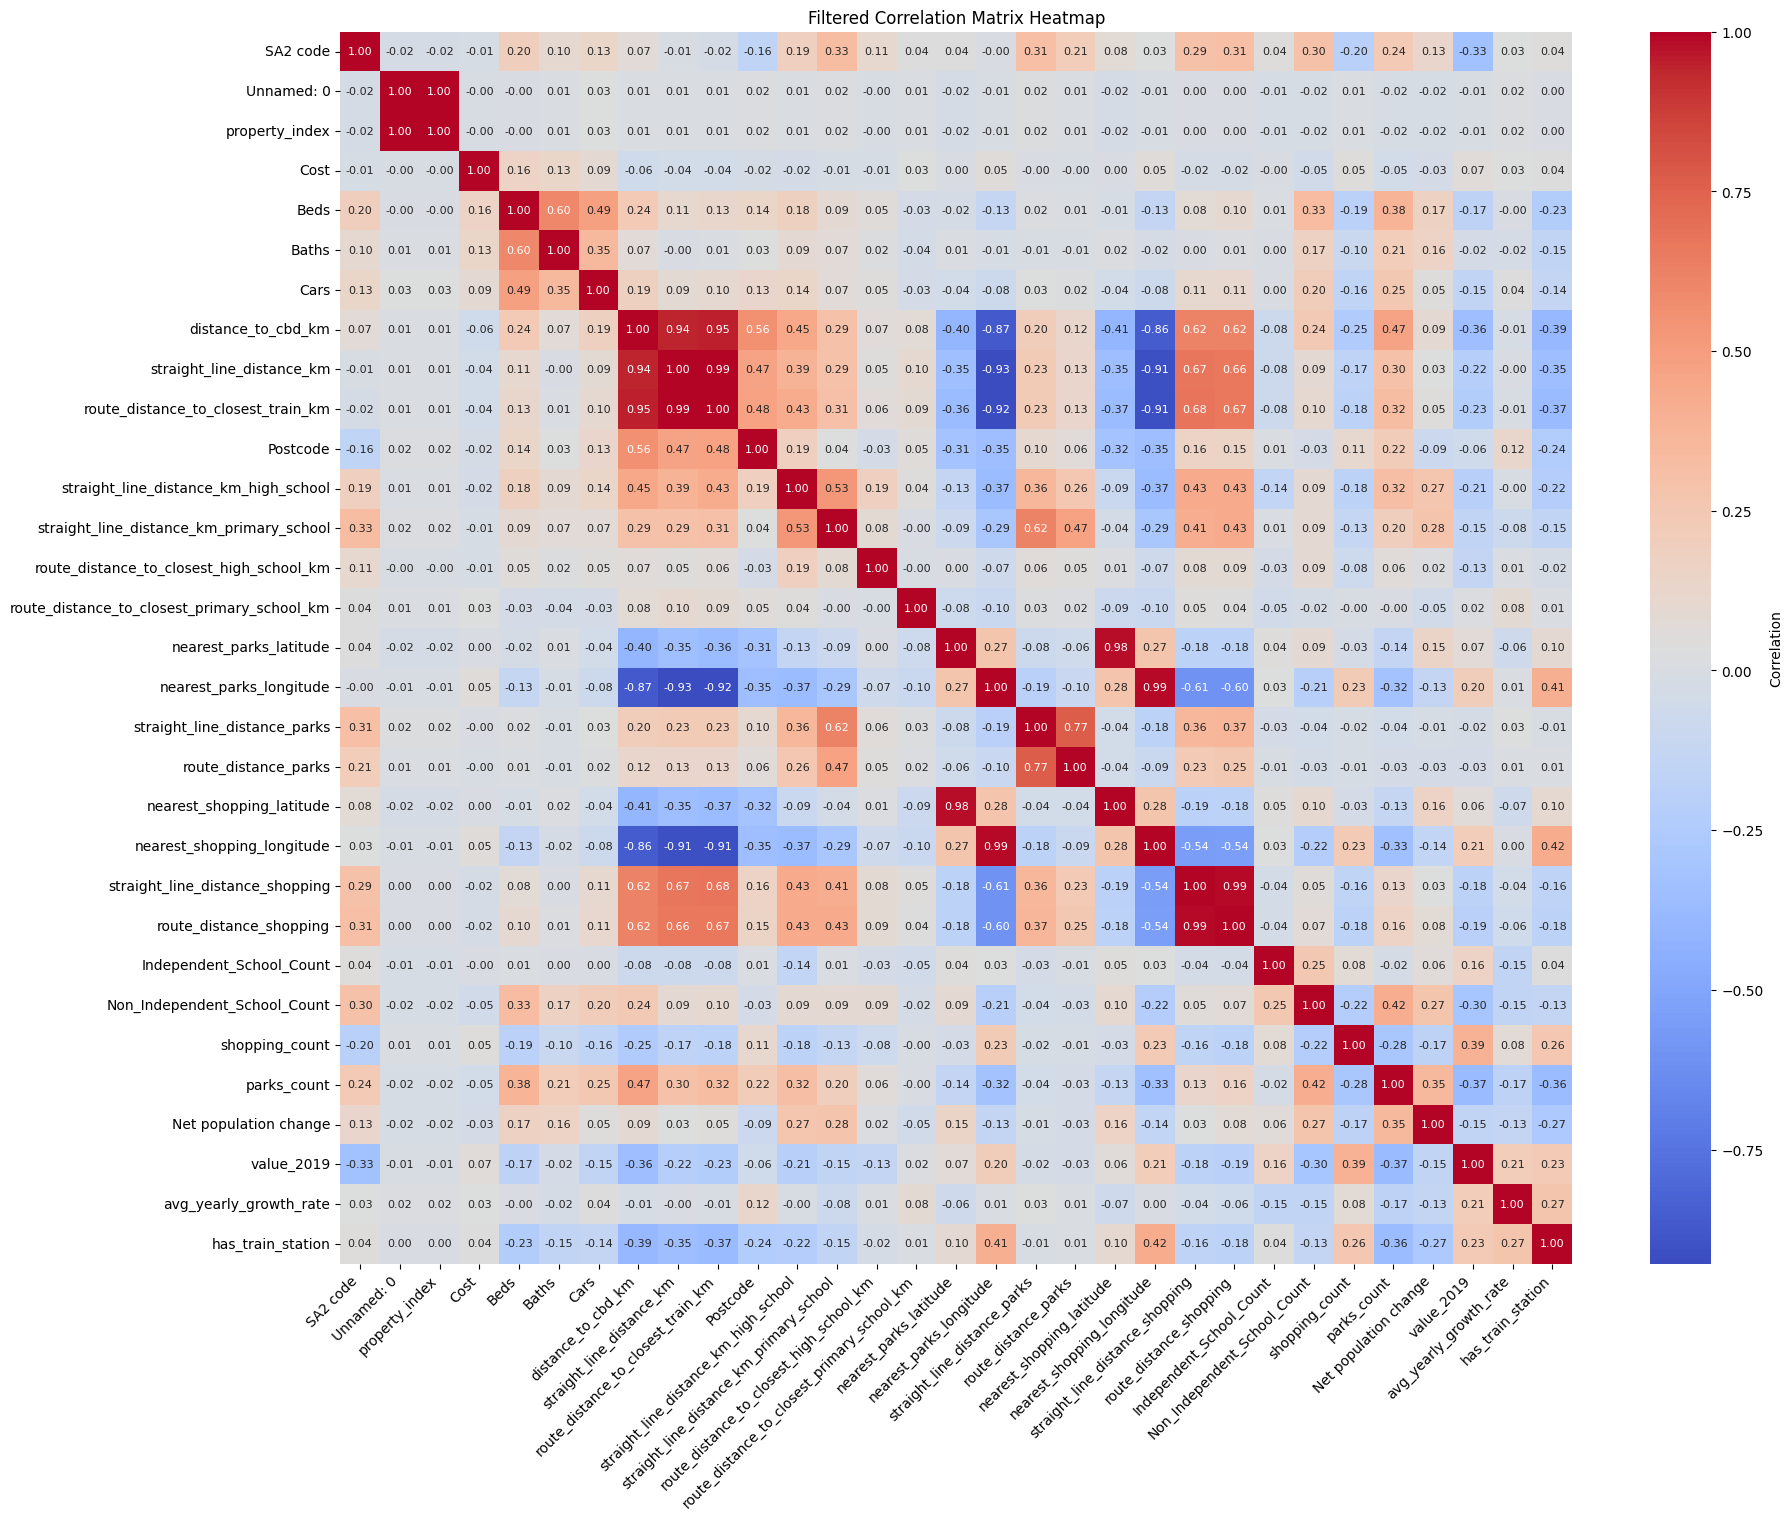

Correlation Matrix:
                                             SA2 code  Unnamed: 0  \
SA2 code                                     1.000000   -0.023969   
Unnamed: 0                                  -0.023969    1.000000   
property_index                              -0.023956    0.999992   
Cost                                        -0.012146   -0.004706   
Beds                                         0.199937   -0.000504   
Baths                                        0.099104    0.009136   
Cars                                         0.133887    0.031669   
distance_to_cbd_km                           0.066805    0.006834   
straight_line_distance_km                   -0.009378    0.007748   
route_distance_to_closest_train_km          -0.017506    0.008376   
Postcode                                    -0.156565    0.018106   
straight_line_distance_km_high_school        0.186461    0.012413   
straight_line_distance_km_primary_school     0.329184    0.015792   
route_distance

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../data/curated/rental_merged.csv')

df['Cars'] = df['Cars'].fillna(0.0)
df.to_csv('../data/curated/rental_merged2.csv')
# One-Hot encode categorical variables
encoded_df = pd.get_dummies(df, columns=['Property Type', 'Suburb', 'closest_high_school_type', 'closest_primary_school_type'], drop_first=True)

# Select numeric columns, including the encoded categorical variables
correlation_df = encoded_df.select_dtypes(include=['float64', 'int64', 'uint8'])

# Generate the correlation matrix
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(20, 16))  # Larger figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=correlation_matrix.isnull(),
            annot_kws={"size": 8},  # Smaller annotation size
            cbar_kws={'label': 'Correlation'}, square=True)

# Adjust the labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the heatmap
plt.title(f'Filtered Correlation Matrix Heatmap')
plt.show()

# Output the correlation matrix as a table
print("Correlation Matrix:")
print(correlation_matrix)

# Optionally, save the correlation matrix to a CSV for detailed analysis
correlation_matrix.to_csv('../data/curated/correlation_matrix.csv')


Training model and outputting results

In [15]:
# Check for missing values in the target column ('Cost')
print(f"Missing values in 'Cost': {df['Cost'].isna().sum()}")

# Drop rows where 'Cost' is missing, since we can't train on rows with missing target values
df = df.dropna(subset=['Cost'])

# Drop irrelevant columns and those with low correlation
df = df.drop(columns=[
    'closest_high_school', 'closest_primary_school', 'nearest_parks_name', 'nearest_shopping_name',
    'closest_train_station', 'Address', 'coordinates', 'Postcode',
    'straight_line_distance_km_high_school', 'straight_line_distance_km_primary_school', 'straight_line_distance_parks',
    'nearest_parks_latitude', 'nearest_parks_longitude', 'straight_line_distance_shopping', 'straight_line_distance_km',
    'property_index', 'nearest_shopping_latitude', 'nearest_shopping_longitude', 'SA2 name',
    'SA2 code', 'Unnamed: 0'
])

# Define the features (X) and target (y)
X = df.drop(columns=['Cost'])  # 'Cost' is the rental price column
y = df['Cost']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline: scaling for numeric features, encoding for categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Imputation and scaling for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean for numeric columns
    ('scaler', StandardScaler())
])

# Imputation and encoding for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent category
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
rf_grid_search.fit(X_train, y_train)

# Get the best parameters
best_rf_model = rf_grid_search.best_estimator_

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")


Missing values in 'Cost': 0
Root Mean Squared Error: 508.53731501210837


/Users/maryzhang/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
std_dev = np.std(y_test)

# Calculate standardized RMSE
standardized_rmse = rmse / std_dev

print(f"RMSE: {rmse}")
print(f"Standardized RMSE: {standardized_rmse}")

RMSE: 508.53731501210837
Standardized RMSE: 1.372871768780035


In [20]:
from sklearn.dummy import DummyRegressor

# Baseline model
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
y_baseline_pred = baseline_model.predict(X_test)
baseline_rmse = mean_squared_error(y_test, y_baseline_pred, squared=False)
baseline_standardized_rmse = baseline_rmse / std_dev

print(f"Baseline RMSE: {baseline_rmse}")
print(f"Baseline Standardized RMSE: {baseline_standardized_rmse}")


Baseline RMSE: 371.1079713077088
Baseline Standardized RMSE: 1.0018609095882252


/Users/maryzhang/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


                                         Feature  Importance
0                                           Beds    0.431704
61                              Suburb_Beaumaris    0.153802
1                                          Baths    0.075818
3                             distance_to_cbd_km    0.073761
2                                           Cars    0.045299
8                        route_distance_shopping    0.042800
14                                    value_2019    0.034819
360                            Suburb_Thomastown    0.030754
5       route_distance_to_closest_high_school_km    0.030363
11                                shopping_count    0.016298
4             route_distance_to_closest_train_km    0.011966
7                           route_distance_parks    0.010104
15                        avg_yearly_growth_rate    0.007003
6    route_distance_to_closest_primary_school_km    0.006508
13                         Net population change    0.004876


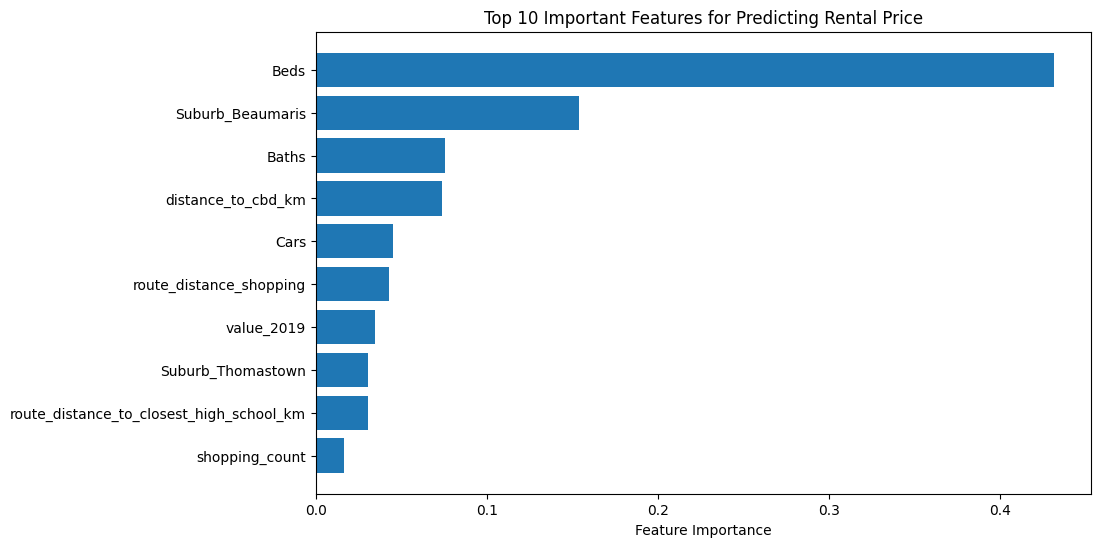

In [18]:
encoder = best_rf_model.named_steps['preprocessor'].transformers_[1][1]  # OneHotEncoder instance
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Combine numeric feature names and encoded categorical feature names
feature_names = list(numeric_features) + list(encoded_feature_names)

# Feature importance
importances = best_rf_model.named_steps['model'].feature_importances_

# Ensure the lengths match between feature names and importances
if len(feature_names) == len(importances):
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    print(importance_df.head(15))
else:
    print(f"Mismatch in lengths: {len(feature_names)} feature names, {len(importances)} importances.")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for Predicting Rental Price')
plt.gca().invert_yaxis()
plt.show()